____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_19 (Convolution2D) (None, 16, 448, 448)  448         convolution2d_input_3[0][0]      
____________________________________________________________________________________________________
leakyrelu_21 (LeakyReLU)         (None, 16, 448, 448)  0           convolution2d_19[0][0]           
____________________________________________________________________________________________________
maxpooling2d_13 (MaxPooling2D)   (None, 16, 224, 224)  0           leakyrelu_21[0][0]               
____________________________________________________________________________________________________
convolution2d_20 (Convolution2D) (None, 32, 224, 224)  4640        maxpooling2d_13[0][0]            
___________________________________________________________________________________________

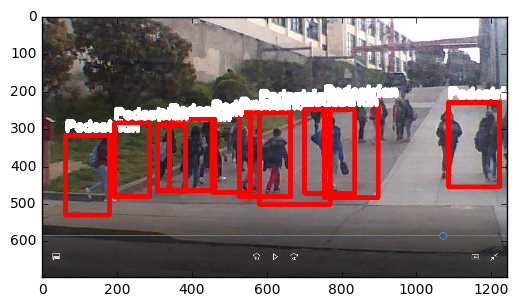

In [3]:
# Code taken from https://github.com/xslittlegrass/CarND-Vehicle-Detection
# Define darknet TINY YOLO v1 network
import urllib.request
import cv2
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Flatten, Dense, Activation, Reshape
keras.backend.set_image_dim_ordering('th')
from scipy.ndimage.measurements import label

model = Sequential()
model.add(Convolution2D(16, 3, 3,input_shape=(3,448,448),border_mode='same',subsample=(1,1)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(64,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(128,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(256,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(512,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(1024,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(Convolution2D(1024,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(Convolution2D(1024,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(Flatten())
model.add(Dense(256))
model.add(Dense(4096))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(1470))

model.summary()

# Code taken from https://github.com/xslittlegrass/CarND-Vehicle-Detection
# Load pre-trained weights
def load_weights(model,yolo_weight_file):
                
    data = np.fromfile(yolo_weight_file,np.float32)
    data=data[4:]
    
    index = 0
    for layer in model.layers:
        shape = [w.shape for w in layer.get_weights()]
        if shape != []:
            kshape,bshape = shape
            bia = data[index:index+np.prod(bshape)].reshape(bshape)
            index += np.prod(bshape)
            ker = data[index:index+np.prod(kshape)].reshape(kshape)
            index += np.prod(kshape)
            layer.set_weights([ker,bia])

#since github won't let me checkin file over 100MB
PATH_TO_WEIGHTS = 'https://pjreddie.com/media/files/yolo-tiny.weights'
#print("Downloading YOLO weights file")
#urllib.request.urlretrieve(PATH_TO_WEIGHTS, './cfg/yolo-tiny.weights')
print("Start loading YOLO weights file into model")
load_weights(model,'./cfg/yolo-tiny.weights')
print("Finish loading YOLO weights file")

# Code taken from https://github.com/xslittlegrass/CarND-Vehicle-Detection
# define blox class, to process results

class Box:
    def __init__(self):
        self.x, self.y = float(), float()
        self.w, self.h = float(), float()
        self.c = float()
        self.prob = float()


def overlap(x1,w1,x2,w2):
    l1 = x1 - w1 / 2.;
    l2 = x2 - w2 / 2.;
    left = max(l1, l2)
    r1 = x1 + w1 / 2.;
    r2 = x2 + w2 / 2.;
    right = min(r1, r2)
    return right - left;

def box_intersection(a, b):
    w = overlap(a.x, a.w, b.x, b.w);
    h = overlap(a.y, a.h, b.y, b.h);
    if w < 0 or h < 0: return 0;
    area = w * h;
    return area;

def box_union(a, b):
    i = box_intersection(a, b);
    u = a.w * a.h + b.w * b.h - i;
    return u;

def box_iou(a, b):
    return box_intersection(a, b) / box_union(a, b);

#classes = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", 
#"diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", 
#"tvmonitor"]
# This function detects persons (class=14)
def yolo_net_out_to_person_boxes(net_out, threshold = 0.2, sqrt=1.8,C=20, B=2, S=7):
    class_num = 14
    boxes = []
    SS        =  S * S # number of grid cells
    prob_size = SS * C # class probabilities
    conf_size = SS * B # confidences for each grid cell
    
    probs = net_out[0 : prob_size]
    confs = net_out[prob_size : (prob_size + conf_size)]
    cords = net_out[(prob_size + conf_size) : ]
    probs = probs.reshape([SS, C])
    confs = confs.reshape([SS, B])
    cords = cords.reshape([SS, B, 4])
    
    for grid in range(SS):
        for b in range(B):
            bx   = Box()
            bx.c =  confs[grid, b]
            bx.x = (cords[grid, b, 0] + grid %  S) / S
            bx.y = (cords[grid, b, 1] + grid // S) / S
            bx.w =  cords[grid, b, 2] ** sqrt 
            bx.h =  cords[grid, b, 3] ** sqrt
            p = probs[grid, :] * bx.c
            #print("threshold: {}, p[{}]: {}".format(threshold, class_num, p[class_num]))
            if p[class_num] >= threshold:
                #print("person prob:", p[class_num])
                bx.prob = p[class_num]
                boxes.append(bx)
                
    # combine boxes that are overlap
    boxes.sort(key=lambda b:b.prob,reverse=True)
    for i in range(len(boxes)):
        boxi = boxes[i]
        if boxi.prob == 0: continue
        for j in range(i + 1, len(boxes)):
            boxj = boxes[j]
            if box_iou(boxi, boxj) >= .4:
                boxes[j].prob = 0.
    boxes = [b for b in boxes if b.prob > 0.]
    
    return boxes

def draw_person_box(boxes,im,crop_dim):
    imgcv = im
    [xmin,xmax] = crop_dim[0]
    [ymin,ymax] = crop_dim[1]
    for b in boxes:
        h, w, _ = imgcv.shape
        left  = int ((b.x - b.w/2.) * w)
        right = int ((b.x + b.w/2.) * w)
        top   = int ((b.y - b.h/2.) * h)
        bot   = int ((b.y + b.h/2.) * h)
        left = int(left*(xmax-xmin)/w + xmin)
        right = int(right*(xmax-xmin)/w + xmin)
        top = int(top*(ymax-ymin)/h + ymin)
        bot = int(bot*(ymax-ymin)/h + ymin)

        if left  < 0    :  left = 0
        if right > w - 1: right = w - 1
        if top   < 0    :   top = 0
        if bot   > h - 1:   bot = h - 1
        thick = int((h + w) // 150)
        cv2.rectangle(imgcv, (left, top), (right, bot), (255,0,0), thick)
        cv2.putText(imgcv, "Pedestrian", (left, top-12), 0, 1.2, (255,255,255), thick)
    return imgcv

def frame_func_person(image):
    crop = image[75:650,:,:]
    resized = cv2.resize(crop,(448,448))
   
    batch = np.array([resized[:,:,0],resized[:,:,1],resized[:,:,2]])
    batch = 2*(batch/255.) - 1
    batch = np.expand_dims(batch, axis=0)
    
    out = model.predict(batch)
    
    boxes = yolo_net_out_to_person_boxes(out[0], threshold = 0.17)
    
    result = draw_person_box(boxes,image,[[0,1280],[75,650]])
    #plt.imshow(aaa)
    #plt.show()
    
    return result

result = frame_func_person(cv2.cvtColor(cv2.imread("./test/test_image28.jpg", 1), cv2.COLOR_BGR2RGB))
plt.imshow(result)
plt.show()


In [ ]:
def YOLOvideoObjectAnotate(Vin, Vout):
    from moviepy.editor import VideoFileClip
    from IPython.display import HTML
    white_output = Vout
    clip1 = VideoFileClip(Vin)
    white_clip = clip1.fl_image(frame_func_person)
    %time white_clip.write_videofile(white_output, audio=False)
    
YOLOvideoObjectAnotate("test_videos/YOLO_MOVI0019_1min32secto3min2sec.mp4", "test_videos/MOVI0019_1min32secto3min2sec_YOLO.mp4")

[MoviePy] >>>> Building video test_videos/MOVI0019_1min32secto3min2sec_YOLO.mp4
[MoviePy] Writing video test_videos/MOVI0019_1min32secto3min2sec_YOLO.mp4


 74%|██████████████████████████████████████████████████████████                    | 1681/2257 [46:59<17:42,  1.84s/it]